# 1. Getting the image

### 1.1 Import 



- Install module

In [ ]:
!pip install svgpathtools

- Import modules and images

In [2]:
from svgpathtools import svg2paths
from svgpathtools import path as Path
from svgpathtools.path import Path as Paths
import numpy as np
import matplotlib.pyplot as plt

paths, attributes = svg2paths('/content/musical-note-music-svgrepo-com.svg')
paths = paths[0]

### 1.2 Create functions to read svg images

- Create functions to read the dots that create the image

In [4]:
from typing import Tuple, List

TupList = Tuple[List[float],List[float]]

def get_path(path: Path,steps = 1000,
             plot: bool = False) -> TupList:
  """This function receives a path in 'svg2paths' standards and return 
  a list of points according to a step"""

  x = np.linspace(0,1,steps)
  real,imag = zip(*[(num.real,-num.imag) for num in path.points(x)])

  if plot:
    plt.plot(real,imag)

  return list(real),list(imag)

100%|██████████| 21/21 [00:00<00:00, 456.34it/s]


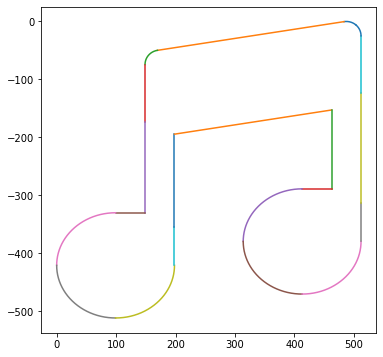

In [5]:
from tqdm import tqdm
plt.figure(figsize = (6,6))

for path in tqdm(paths):

  real, imag = get_path(path)

  plt.plot(real, imag)

plt.show()

In [6]:
def lerp(z1: complex, z2: complex, p: float) -> complex:
  return (1-p)*z1 + p*z2

def breakNum(x:float) -> Tuple[int,float]:
  int_part = int(x)
  float_part = x - int_part
  return (int_part,float_part)

In [24]:
from typing import Union,Callable,Tuple

TupList = Tuple[List[float],List[float]]
TupFloat = Tuple[float,float]

def getPathsCombined(paths: Paths, 
                     steps: int = 1000,
                     getFunction: bool = False,
                     plot: bool = False) -> Union[TupList, Callable[[float],TupFloat]]:

  """This function takes in a list of paths and return either the points
  that form the curve, or a function that describes the curve."""

  real_data = []
  imag_data = []

  for path in paths:
    real, imag = get_path(path,steps = steps)
    
    real_data += real
    imag_data += imag


  real_mean = np.mean(real_data)
  imag_mean = np.mean(imag_data)

  real_delta = (max(real_data)-min(real_data))
  imag_delta = (max(imag_data)-min(imag_data))

  real_data = list(map(lambda x: (x - real_mean)/real_delta, real_data))
  imag_data = list(map(lambda x: (x - imag_mean)/imag_delta, imag_data))

  if getFunction:
    L = len(real_data)

    def func(p: float) -> complex:
      if p == 1:
        return complex(real_data[-1],imag_data[-1])

      n_int,n_float = breakNum(L*p)
      n_next = n_int + 1 if n_int != L - 1 else 0

      n1 = complex(real_data[n_int],imag_data[n_int])
      n2 = complex(real_data[n_next],imag_data[n_next])

      return lerp(n1,n2,n_float)
      
    return func

  if plot:
    plt.plot(real_data,imag_data)
    
  return real_data, imag_data

- Print the image

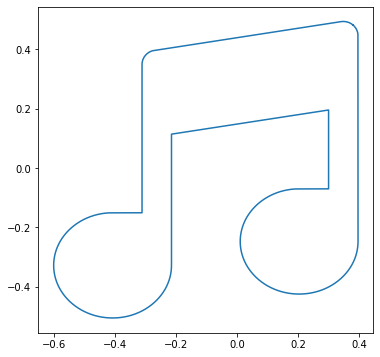

In [22]:
plt.figure(figsize = (6,6))
getPathsCombined(paths,plot = True,steps = 1000)
plt.show()

# 2. Fourier

### 2.1 Fourier for given frequency

In [25]:
def fourier(f: Callable,
            n: int,
            N: int = 5000) -> complex:
            
  """For a given path function, this function finds the vector in it's inicial
  position given a frequency n"""

  def f_exp(t: float):
    c = -2*np.pi*n*t
    return complex(np.cos(c),np.sin(c))

  return sum(f(x)*f_exp(x)*(1/N) for x in np.linspace(0,1,N))


### 2.2 Fourier for entire image

In [26]:
from tqdm import tqdm
def findFourierPoints(f: Callable,
                      interval = np.arange(-10,11),
                      N: int = 5000) -> List[complex]:
  """Given a collection of Paths, this functions finds all the inicial
  positions of each vector that composes the image"""

  fourier_points = []
  for freq in tqdm(interval):
    fp = fourier(f,freq,N=N)
    
    fourier_points.append((freq,fp.real,fp.imag))
  return fourier_points


### 2.3 Intercalate list (for visual part)

In [27]:
def intercalate(L: List)->List:
  """This function splits a list in the middle then intercalate
  the two halves. Example: [-3,-2,-1,0,1,2,3] -> [0,1,-1,2,-2,3,-3]"""
  
  a = 1 if len(L)%2 == 0 else 0 #Ajust variable for len(L) odd or even
  
  r = [0]*len(L)
  r[::2] = L[len(L)//2 - a::-1]
  r[1::2] = L[len(L)//2 + (1 - a):]

  return r

intercalate([i for i in range(-3,4)])

[0, 1, -1, 2, -2, 3, -3]

### Find vector's initial positions

In [28]:
f = getPathsCombined(paths, getFunction = True,steps = 1000) #Function for the given image
points = findFourierPoints(f,
                      interval = np.arange(-200,201),
                      N = 5000)

points = intercalate(points)

100%|██████████| 401/401 [00:27<00:00, 14.49it/s]


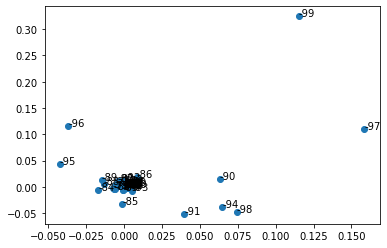

In [29]:
freq, real,imag = zip(*points)
plt.scatter(real,imag)
labels = np.arange(-100,101)

for i, text in enumerate(labels):
  plt.annotate(labels[i],(real[i],imag[i]))
plt.show()

# Animate

In [30]:
from dataclasses import dataclass


class Line:
  def __init__(self,lw = 3,color = 'b'):
    self.lw = lw
    self.color = color
    self.plot = plt.plot([],[],lw = self.lw, color = self.color)
  
  def set_data(self,x,y):
    self.line, = self.plot
    self.line.set_data(x,y)

  def return_line(self):
    return self.line,


class Circle(Line):
  def __init__(self,lw = 1, color = 'b'):
      super().__init__(lw = lw, color = color)
      
  def draw(self,x,y,r):
    x_data = [r*np.cos(2*np.pi*i) + x for i in np.linspace(0,1,60)]
    y_data = [r*np.sin(2*np.pi*i) + y for i in np.linspace(0,1,60)]

    self.line, = self.plot
    self.line.set_data(x_data,y_data)

In [33]:
# importing required libraries
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython import display
from matplotlib import rc
rc('animation', html='jshtml')


def create_animation(points: List[complex]) -> None:
  #Start figure
  fig = plt.figure(figsize = (10,10))
  fig.set_facecolor('black')

  ax = plt.axes()
  ax.set_facecolor("black")


  # Line between vectors
  line, = plt.plot([], [], lw = 1,color = 'white')

  # Line drawing the image
  draw, = plt.plot([], [], lw=1,color = '#7ed941')
  draw_x = []
  draw_y = []

  # Circles
  circles = [Circle(color = '#5a5e5e') for _ in range(len(points))]

  # Points
  pts, = plt.plot([],[],'o',ms = 3,color = '#79a9e0')

  # Labels
  plt.xlabel('real axis')
  plt.ylabel('imaginary axis')
  plt.title('Fourier Series')

  plt.xlim(-1,1)
  plt.ylim(-1,1)

  FRAMES = 60
  def animate(frame_number):
      fig.set_facecolor('black')  
      alpha = frame_number*2*np.pi/60

      x = [0]
      y = [0]
      for k in range(len(points)):
        point = points[k]
        f,r,i = point
        a = abs(complex(r,i))
        f /= 10 # Slow down by a factor of ten

        # Rotate each vector by their respective amount
        num = complex(r,i)
        multiplier = complex(np.cos(alpha*f),np.sin(alpha*f))

        rotated_num = num*multiplier

        x.append(x[-1] + rotated_num.real)
        y.append(y[-1] + rotated_num.imag)

        # Add circles
        if k < 10 or a > 0.5:
          circle = circles[k]
          circle.draw(x[-2],y[-2],a)

      line.set_data(x, y)
      line.set_color('white')

      draw_x.append(x[-1])
      draw_y.append(y[-1])
      draw.set_data(draw_x,draw_y)

      pts.set_data(x,y)
      return (line, draw, pts) 


  anim = animation.FuncAnimation(fig, animate,frames= 10*FRAMES, 
                                interval=100, blit=True)


  # converting to an html5 video
  video = anim.to_html5_video()

  # embedding for the video
  html = display.HTML(video)
    
  # draw the animation
  display.display(html)
  plt.close()

In [34]:
create_animation(points)